# Investigate Orientation Wind and Currents Grids for WaveWatch

ww3 requires wind and currents forcing files to be on a 
"spherical lat-long grid, with constant dlon, dlat"
(maybe the same as a [plate carrée](https://en.wikipedia.org/wiki/Equirectangular_projection)
grid?).
This notebook examines the Salish Sea NEMO atmospheric forcing files like

`/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m03d17.nc`

and the `u` and `v` current component output files like

`/results/SalishSea/nowcast-blue/17mar17/SalishSea_1h_20170317_20170317_grid_U.nc`

and

`/results/SalishSea/nowcast-blue/17mar17/SalishSea_1h_20170317_20170317_grid_V.nc`

and their associated mesh mask file:

`NEMO-forcing/grid/mesh_mask_downbyone2.nc`

or the

https://salishsea.eos.ubc.ca/erddap/info/ubcSSn2DMeshMask2V16-07/index.html

ERDDAP dataset,
to determine what transformation of them is required to produce input wind and current files
for ww3.

The mesh mask file is required because the latitudes and longitudes of the velocity grid points
are not stored in the `*grid_Ū.nc` and `*grid_V.nc` files.

In [165]:
import arrow
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import xarray as xr

In [2]:
%matplotlib inline

## WaveWatch Grid

In [3]:
wwf = xr.open_dataset('SoG_ww3_fields_20170121_20170123.nc')
wwf

<xarray.Dataset>
Dimensions:    (latitude: 661, longitude: 572, time: 120)
Coordinates:
  * longitude  (longitude) float32 234.0 234.007 234.014 234.021 234.028 ...
  * latitude   (latitude) float32 48.0 48.0045 48.009 48.0135 48.018 48.0225 ...
  * time       (time) datetime64[ns] 2017-01-21 2017-01-21T00:29:59.971200 ...
Data variables:
    MAPSTA     (latitude, longitude) int16 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 ...
    ucur       (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    vcur       (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    uwnd       (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    vwnd       (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    hs         (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    lm         (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    t02        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    fp         (time, lat

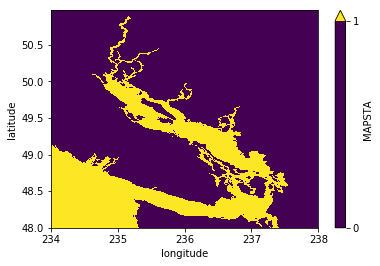

In [4]:
# Whole wwatch3 domain land mask
wwf.MAPSTA.plot(levels=[0, 1])

## Wind

In [4]:
meteo = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m03d17.nc')
meteo

<xarray.Dataset>
Dimensions:       (time_counter: 24, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-03-17 ...
  * x             (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * y             (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
Data variables:
    atmpres       (time_counter, y, x) float64 1.023e+05 1.023e+05 1.023e+05 ...
    nav_lat       (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 ...
    nav_lon       (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
    precip        (time_counter, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    qair          (time_counter, y, x) float64 0.005553 0.005538 0.005526 ...
    solar         (time_counter, y, x) float64 359.8 348.6 315.3 304.2 304.2 ...
    tair          (time_counter, y, x) float64 282.3 282.3 282.3 282.3 282.3 ...
    therm_rad     (time_counter, y, x) float64 304.2 308.7 317.6 322.0 317.6 ...
    u_wind        (time_counter, y, x) float64 3.

(<xarray.DataArray 'nav_lat' ()>
 array(45.564901), <xarray.DataArray 'nav_lat' ()>
 array(52.27926367151701))

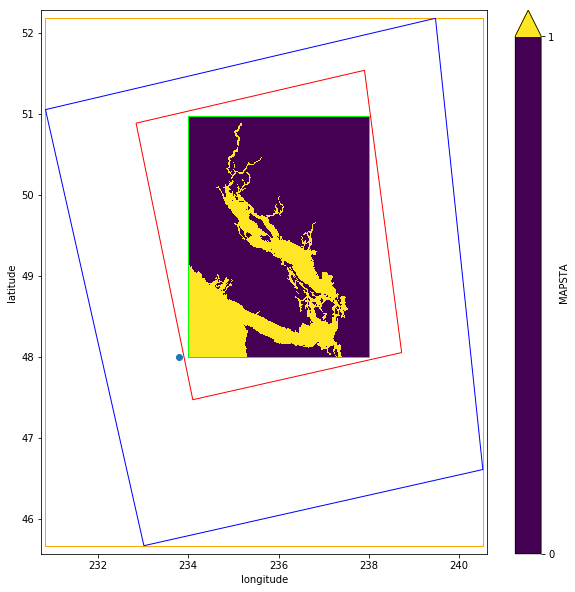

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

wwf.MAPSTA.plot(ax= ax, levels=[0, 1])

vertices = [
    (wwf.longitude.min(), wwf.latitude.min()),
    (wwf.longitude.min(), wwf.latitude.max()),
    (wwf.longitude.max(), wwf.latitude.max()),
    (wwf.longitude.max(), wwf.latitude.min()),
]
codes = [Path.MOVETO] + [Path.LINETO]*(len(vertices)-1) + [Path.CLOSEPOLY]
vertices.append(vertices[-1])
vertices = np.array(vertices, float)
path = Path(vertices, codes)
pathpatch = PathPatch(path, facecolor='None', edgecolor='lime')
ax.add_patch(pathpatch)

vertices = [
    (meteo.nav_lon.min(), meteo.nav_lat.min()),
    (meteo.nav_lon.min(), meteo.nav_lat.max()),
    (meteo.nav_lon.max(), meteo.nav_lat.max()),
    (meteo.nav_lon.max(), meteo.nav_lat.min()),
]
codes = [Path.MOVETO] + [Path.LINETO]*(len(vertices)-1) + [Path.CLOSEPOLY]
vertices.append(vertices[-1])
vertices = np.array(vertices, float)
path = Path(vertices, codes)
pathpatch = PathPatch(path, facecolor='None', edgecolor='orange')
ax.add_patch(pathpatch)

vertices = [
    (meteo.nav_lon[0, 0], meteo.nav_lat[0, 0]),
    (meteo.nav_lon[-1, 0], meteo.nav_lat[-1, 0]),
    (meteo.nav_lon[-1, -1], meteo.nav_lat[-1, -1]),
    (meteo.nav_lon[0, -1], meteo.nav_lat[0, -1]),
]
codes = [Path.MOVETO] + [Path.LINETO]*(len(vertices)-1) + [Path.CLOSEPOLY]
vertices.append(vertices[-1])
vertices = np.array(vertices, float)
path = Path(vertices, codes)
pathpatch = PathPatch(path, facecolor='None', edgecolor='blue')
ax.add_patch(pathpatch)

vertices = [
    (meteo.nav_lon[76, 55], meteo.nav_lat[76, 55]),
    (meteo.nav_lon[242, 55], meteo.nav_lat[242, 55]),
    (meteo.nav_lon[242, 206], meteo.nav_lat[242, 206]),
    (meteo.nav_lon[76, 206], meteo.nav_lat[76, 206]),
]
codes = [Path.MOVETO] + [Path.LINETO]*(len(vertices)-1) + [Path.CLOSEPOLY]
vertices.append(vertices[-1])
vertices = np.array(vertices, float)
path = Path(vertices, codes)
pathpatch = PathPatch(path, facecolor='None', edgecolor='red')
ax.add_patch(pathpatch)

ax.plot(meteo.nav_lon[103, 51], meteo.nav_lat[103, 51], 'o')

ax.set_xlim(meteo.nav_lon.min()-0.1, meteo.nav_lon.max()+0.1)
ax.set_ylim(meteo.nav_lat.min()-0.1, meteo.nav_lat.max()+0.1)

In [46]:
meteo.nav_lon[76:-24, 55:-50].min()

<xarray.DataArray 'nav_lon' ()>
array(232.85043813773942)

In [150]:
wx, wy = np.meshgrid(wwf.longitude[::5], wwf.latitude[::5])
wx[:, -1] = 238

In [151]:
wx.shape, wy.shape

((133, 115), (133, 115))

In [6]:
time = 0
y_slice = slice(76, 159)  # 76, 242
x_slice = slice(55, 206)  # 55, 206

In [7]:
u_interp = interpolate.Rbf(
    meteo.nav_lon[y_slice, x_slice], meteo.nav_lat[y_slice, x_slice], meteo.u_wind[time, y_slice, x_slice],
)

In [8]:
v_interp = interpolate.Rbf(
    meteo.nav_lon[y_slice, x_slice], meteo.nav_lat[y_slice, x_slice], meteo.v_wind[time, y_slice, x_slice],
)

In [24]:
meteo.nav_lon[:-24, :-50].shape

(242, 206)

In [29]:
(242-76)/2, 206-55, 76+83

(83.0, 151, 159)

In [152]:
u_wind = u_interp(wx, wy)
v_wind = v_interp(wx, wy)

(47.85375003814697, 51.071249198913577)

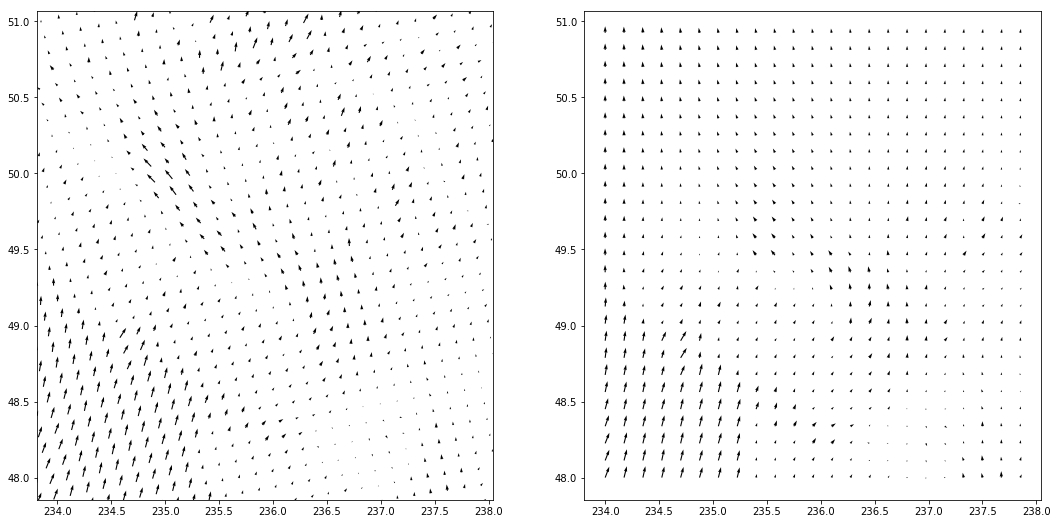

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
units = 'dots'
axs[0].quiver(
    meteo.nav_lon[::5, ::5], meteo.nav_lat[::5, ::5], 
    meteo.u_wind[time][::5, ::5], meteo.v_wind[time][::5, ::5],
    units=units, scale_units=units, scale=1,
)
axs[1].quiver(
    wx[::5, ::5], wy[::5, ::5], u_wind[::5, ::5], v_wind[::5, ::5],
    units=units, scale_units=units, scale=1,
)

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())

In [24]:
print(wx[0, 0], wy[0, 0])
print(u_wind[0, 0], v_wind[0, 0])

234.0 48.0
4.11331779943 10.9031430942


In [80]:
mj, mi = 104, 55
print(meteo.nav_lon.values[mj, mi], meteo.nav_lat.values[mj, mi])
print(meteo.u_wind.values[time, mj, mi], meteo.v_wind.values[time, mj, mi])

233.902742768 48.0401610101
4.40066480637 10.6493330002


In [95]:
u_wind.shape

(133, 115)

In [154]:
wx[:, -1]

array([ 238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,  238.,
        238.,  238.,

In [169]:
lats = xr.DataArray(
    name='latitude',
    data=wy[:, 0],
    dims=('latitude')
)
lons = xr.DataArray(
    name='longitude',
    data=wx[0, :],
    dims=('longitude')
)
time_dim = xr.DataArray(
    name='time',
    data=np.array([arrow.get('2017-03-17 00:00:00').datetime]),
    dims=('time'),
    attrs={
        'time_origin': '2017-03-17 00:00:00',
    },
)
ww_wind = xr.Dataset(
    data_vars={
        'u_wind': xr.DataArray(
            name='u_wind',
            data=np.expand_dims(u_wind, axis=0),
            dims=('time', 'latitude', 'longitude'),
        ),
        'v_wind': xr.DataArray(
            name='v_wind',
            data=np.expand_dims(v_wind, axis=0),
            dims=('time', 'latitude', 'longitude'),
        ),
    },
    coords={
        'latitude': lats,
        'longitude': lons,
        'time': time_dim,
    },
)
ww_wind

<xarray.Dataset>
Dimensions:    (latitude: 133, longitude: 115, time: 1)
Coordinates:
  * latitude   (latitude) float64 48.0 48.02 48.04 48.07 48.09 48.11 48.13 ...
  * longitude  (longitude) float64 234.0 234.0 234.1 234.1 234.1 234.2 234.2 ...
  * time       (time) datetime64[ns] 2017-03-17
Data variables:
    u_wind     (time, latitude, longitude) float64 4.113 3.76 3.44 3.145 ...
    v_wind     (time, latitude, longitude) float64 10.9 11.02 11.12 11.19 ...

In [171]:
ww_wind.to_netcdf(
    'SoG_wind_20170317.nc',
    encoding={'time': {'units': 'hours since 2017-03-17'}},
    unlimited_dims=('time',),
)

In [246]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m04d06.nc')

In [247]:
hrdps.nav_lat

<xarray.DataArray 'nav_lat' (y: 266, x: 256)>
array([[ 45.664901,  45.66989 ,  45.674869, ...,  46.601005,  46.603365,
         46.605715],
       [ 45.684955,  45.689948,  45.69493 , ...,  46.621673,  46.624035,
         46.626387],
       [ 45.705012,  45.710008,  45.714993, ...,  46.642345,  46.644709,
         46.647061],
       ..., 
       [ 51.010078,  51.016028,  51.021966, ...,  52.130846,  52.133684,
         52.136509],
       [ 51.030647,  51.036601,  51.042543, ...,  52.152218,  52.155058,
         52.157885],
       [ 51.051217,  51.057175,  51.063121, ...,  52.173593,  52.176435,
         52.179264]])
Coordinates:
  * x        (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * y        (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
Attributes:
    units: degrees_north
    long_name: latitude

In [248]:
hrdps.u_wind.rename({'y': 'latitude', 'x': 'longitude'})

<xarray.DataArray 'u_wind' (time_counter: 24, latitude: 266, longitude: 256)>
[1634304 values with dtype=float64]
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-04-06 ...
  * longitude     (longitude) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 ...
  * latitude      (latitude) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 ...
Attributes:
    short_name: UGRD_10maboveground
    long_name: U-Component of Wind
    level: 10 m above ground
    units: m/s
    coordinates: longitude latitude

In [273]:
ds = xr.Dataset(
    data_vars={
        'u_wind': hrdps.u_wind.rename({'time_counter': 'time'}),
        'v_wind': hrdps.v_wind.rename({'time_counter': 'time'}),
    },
    coords={
        'time': hrdps.time_counter.rename('time').rename({'time_counter': 'time'}),
        'latitude': hrdps.nav_lat,
        'longitude': hrdps.nav_lon,
    }
)
del ds.u_wind.attrs['coordinates']
del ds.v_wind.attrs['coordinates']
ds

<xarray.Dataset>
Dimensions:    (time: 24, x: 256, y: 266)
Coordinates:
  * time       (time) datetime64[ns] 2017-04-06 2017-04-06T01:00:00 ...
  * x          (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * y          (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
    latitude   (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 45.7 ...
    longitude  (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
Data variables:
    u_wind     (time, y, x) float64 -2.255 -2.235 -2.21 -2.195 -2.17 -2.15 ...
    v_wind     (time, y, x) float64 -1.141 -1.191 -1.236 -1.276 -1.321 ...

In [275]:
ds.latitude

<xarray.DataArray 'latitude' (y: 266, x: 256)>
array([[ 45.664901,  45.66989 ,  45.674869, ...,  46.601005,  46.603365,
         46.605715],
       [ 45.684955,  45.689948,  45.69493 , ...,  46.621673,  46.624035,
         46.626387],
       [ 45.705012,  45.710008,  45.714993, ...,  46.642345,  46.644709,
         46.647061],
       ..., 
       [ 51.010078,  51.016028,  51.021966, ...,  52.130846,  52.133684,
         52.136509],
       [ 51.030647,  51.036601,  51.042543, ...,  52.152218,  52.155058,
         52.157885],
       [ 51.051217,  51.057175,  51.063121, ...,  52.173593,  52.176435,
         52.179264]])
Coordinates:
  * x          (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * y          (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
    latitude   (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 45.7 ...
    longitude  (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
Attributes:
    units: degrees_north
    long

In [274]:
ds.to_netcdf('SoG_wind_20170406.nc')

Use http://www.movable-type.co.uk/scripts/latlong.html to calculate grid point to grid point bearings:

### SW corner

In [9]:
print(meteo.nav_lat[0:2, 0].data)
print(meteo.nav_lon[0:2, 0].data)

[ 45.664901    45.68495545]
[ 233.015505   233.0083553]


Initial bearing: 	346° 00′ 52″

Final bearing: 	346° 00′ 34″

In [10]:
print(meteo.nav_lat[0, 0:2].data)
print(meteo.nav_lon[0, 0:2].data)

[ 45.664901    45.66989016]
[ 233.015505    233.04420318]


Initial bearing: 	076° 01′ 11″

Final bearing: 	076° 02′ 24″

### SE corner

In [12]:
print(meteo.nav_lat[0:2, -1].data)
print(meteo.nav_lon[0:2, -1].data)

[ 46.60571492  46.62638675]
[ 240.52961343  240.52619937]


Initial bearing: 	353° 31′ 45″

Final bearing: 	353° 31′ 36″

In [13]:
print(meteo.nav_lat[0, -2:].data)
print(meteo.nav_lon[0, -2:].data)

[ 46.60336524  46.60571492]
[ 240.49952793  240.52961343]


Initial bearing: 	083° 30′ 13″

Final bearing: 	083° 31′ 32″

### NW corner

In [14]:
print(meteo.nav_lat[-2:, 0].data)
print(meteo.nav_lon[-2:, 0].data)

[ 51.03064696  51.05121732]
[ 230.84253367  230.83305233]


Initial bearing: 	343° 50′ 30″

Final bearing: 	343° 50′ 03″

In [15]:
print(meteo.nav_lat[-1, 0:2].data)
print(meteo.nav_lon[-1, 0:2].data)

[ 51.05121732  51.05717517]
[ 230.83305233  230.86578181]


Initial bearing: 	073° 50′ 12″

Final bearing: 	073° 51′ 44″

### NE Corner

In [16]:
print(meteo.nav_lat[-2:, -1].data)
print(meteo.nav_lon[-2:, -1].data)

[ 52.15788498  52.17926367]
[ 239.4839078   239.47930752]


Initial bearing: 	352° 29′ 00″

Final bearing: 	352° 28′ 47″

## Currents

In [22]:
mesh = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMask2V16-07')

In [23]:
mesh

<xarray.Dataset>
Dimensions:    (gridX: 398, gridY: 898, gridZ: 40)
Coordinates:
  * gridZ      (gridZ) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * gridY      (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * gridX      (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    e1t        (gridZ, gridY, gridX) float64 ...
    e2t        (gridZ, gridY, gridX) float64 ...
    e1u        (gridZ, gridY, gridX) float64 ...
    e2u        (gridZ, gridY, gridX) float64 ...
    e1v        (gridZ, gridY, gridX) float64 ...
    e2v        (gridZ, gridY, gridX) float64 ...
    e1f        (gridZ, gridY, gridX) float64 ...
    e2f        (gridZ, gridY, gridX) float64 ...
    glamt      (gridZ, gridY, gridX) float64 ...
    gphit      (gridZ, gridY, gridX) float64 ...
    glamu      (gridZ, gridY, gridX) float64 ...
    gphiu      (gridZ, gridY, gridX) float64 ...
    glamv      (gridZ, gridY, gridX) float64 ...
    glamf      (gridZ, gri

In [25]:
mesh.gphiu, mesh.glamu

(<xarray.DataArray 'gphiu' (gridZ: 40, gridY: 898, gridX: 398)>
 [14296160 values with dtype=float64]
 Coordinates:
   * gridZ    (gridZ) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
   * gridY    (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
   * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
 Attributes:
     long_name: latitude of U-grid points
     standard_name: gphiu
     units: degrees_north,
 <xarray.DataArray 'glamu' (gridZ: 40, gridY: 898, gridX: 398)>
 [14296160 values with dtype=float64]
 Coordinates:
   * gridZ    (gridZ) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
   * gridY    (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
   * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
 Attributes:
     long_name: longitude of U-grid points
     standard_name: glamu
     units: degrees_east)

### SW Corner

In [29]:
print(mesh.gphiu[0, 0:2, 0].data)
print(mesh.glamu[0, 0:2, 0].data)

[ 46.86060715  46.86380005]
[-123.42677307 -123.42937469]


Initial bearing: 	330° 52′ 38″
Final bearing: 	330° 52′ 31″